## Evaluation for the NLP class @ Emines (January 2022)

### Exercise 1: Improving the performances of a sentiment analysis classifier
**From the [notebook of day 2](https://colab.research.google.com/drive/1m3DSxqi3tnBBe6niKpggKw0i2uo1rgs7?usp=sharing), try to improve the performances of the sentiment analysis classifier by trying the following changes in the model/algorithm/preprocessing procedure**.  
To evaluate the performances, look at the validation accuracy. 

1. Preprocessing: in the original dataset, remove stop_words and do some stemming (see https://www.nltk.org/howto/stem.html documentation)
> Does it improve performance ? 

2. Model architecture changes: 
    * Replace the trainable embedding layer by an embedding layer which loads GloVe embeddings (see TP of day #1). 
    * Use several layers of LSTM
    * Add a Dense Layer after the LSTM and before the final Dense Projection Layer 
    * Use a bi-directionnal LSTM using https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    * Take the average of the sequence of hidden states as the sentence encoding (instead of the final hidden state)
> Do you find an architecture that improves the performance of the classifier ? 

3. Training algorithm / hyper-parameters search
*  add gradient clipping to limit exploding gradients: https://www.tensorflow.org/api_docs/python/tf/clip_by_norm
* do hyperparameter-search on model dimensions, dropout rate, training hyper-parameters (learning rate, batch size) to reach a better val accuracy.
> Which set of hyper-parameters work the best ? 


In [2]:
# install datasets
!pip install datasets

# Make sure that we have a recent version of pyarrow in the session before we continue - otherwise reboot Colab to activate it
import pyarrow
if int(pyarrow.__version__.split('.')[1]) < 16 and int(pyarrow.__version__.split('.')[0]) == 0:
    import os
    os.kill(os.getpid(), 9)

     |████████████████████████████████| 311 kB 5.5 MB/s 
     |████████████████████████████████| 243 kB 47.9 MB/s 
     |████████████████████████████████| 1.1 MB 46.3 MB/s 
     |████████████████████████████████| 133 kB 51.6 MB/s 
     |████████████████████████████████| 67 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 62.7 MB/s 
     |████████████████████████████████| 144 kB 59.6 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 


In [3]:
# imports
from datasets import load_dataset
from pprint import pprint
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

In [4]:
# new imports 
from nltk.stem.porter import *
from nltk.corpus import stopwords
import copy

## 1. Preprocess and Explore Dataset

### 1.1 Load the dataset

In [55]:
dataset = load_dataset('sst')
train_set, val_set, test_set = dataset["train"], dataset["validation"], dataset["test"]
print("len train dataset", len(train_set))
print("len val dataset", len(val_set))
print("len test set", len(test_set))

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

len train dataset 8544
len val dataset 1101
len test set 2210


This create a `Dataset` object (a kind of list of dictionnaries), for which you can iterate on samples like an Numpy Array.

In [6]:
print(train_set.column_names)
for k,v in train_set[0].items():
  print(k,v)

['sentence', 'label', 'tokens', 'tree']
sentence The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
label 0.6944400072097778
tokens The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.
tree 70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0


### 1.2 Binarize labels

In [7]:
def binarize_label(example):
  label = example['label']
  if label > 0.6:
    example["binary_label"] = 1 # positive label
  elif label < 0.4:
    example["binary_label"] = 0 # negative label. 
  else: 
    example["binary_label"] = 2 # neutral labels. 
  return example

In [8]:
def get_binary_labels(dataset):
  processed_dataset = dataset.map(binarize_label)
  return processed_dataset

In [9]:
train_set = get_binary_labels(train_set)
val_set = get_binary_labels(val_set)
test_set = get_binary_labels(val_set)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

**Exercise 1**:  
1. Create a function `visualize_labels` that visualizes labels distribution using `plt.hist`
2. Create a function `select_sequence_from_label` that samples movie reviews with a specific label value

In [10]:
def visualize_labels(dataset):
  plt.hist(dataset['label'], 20, density=True, facecolor='g', alpha=0.75)

In [11]:
def select_sequence_from_label(dataset, label, num_samples=5, epsilon=0.025):
  # label - epsilon -> label + epsilon
  dataset_with_label = dataset.filter(lambda example: label - epsilon <= example['label']<= label+epsilon)
  print("samples from label:", label)
  pprint(dataset_with_label["sentence"][0:num_samples], compact=True)

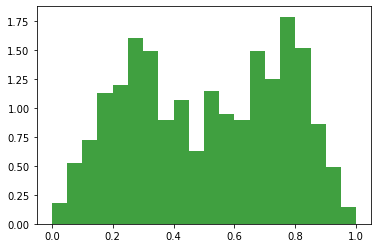

In [12]:
visualize_labels(train_set)

In [13]:
select_sequence_from_label(train_set, 0.9, num_samples=5, epsilon=0.025)

  0%|          | 0/9 [00:00<?, ?ba/s]

samples from label: 0.9
['Just the labour involved in creating the layered richness of the imagery in '
 'this chiaroscuro of madness and light is astonishing .',
 'Good fun , good action , good acting , good dialogue , good pace , good '
 'cinematography .',
 'Grenier is terrific , bringing an unforced , rapid-fire delivery to Toback '
 "'s Heidegger - and Nietzsche-referencing dialogue .",
 'The wanton slipperiness of \\* Corpus and its amiable jerking and reshaping '
 'of physical time and space would make it a great piece to watch with kids '
 'and use to introduce video as art .',
 'I walked away from this new version of E.T. just as I hoped I would -- with '
 'moist eyes .']


### 1.1 Text Cleaning
**Exercise 2**: 
Create a function `tokenize_sentence` that cleans and tokenize the "tokens" column, as follows: 

In [14]:
def tokenize(dataset, stem_stop = False):
  def tokenize_sentence(example):
    # all letters in lower case and tokenize
    example["tokens"] = example["tokens"].lower().split("|")
    # remove punctuation.
    example["tokens"] = [w for w in example["tokens"] if w.isalpha()]
    return example
  processed_dataset = dataset.map(tokenize_sentence)
  if stem_stop :
    return process_stem_stop(dataset, stem =True, stop=True)
  else : 
    return processed_dataset
  

In [19]:
import nltk
from nltk.stem import *
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
#data = tokenize(train_set)
def process_stem_stop(dataset, stem =False, stop=False):
  data = tokenize(dataset)
  # Drop the stop words
  if stop : 
    tok=[]
    for i in data['tokens'] :
      filtered_sentence = []
      for token in i:
        if token not in stop_words:
          filtered_sentence.append(token)
      tok.append(filtered_sentence)

  # Stem words
  if stem : 
    new_train = data
    new_tokens = [[stemmer.stem(i) for i in j] for j in tok]
    stem_stop_tokens = new_train.add_column("new_tokens", new_tokens)
    #data['new_tokens'] = [[stemmer.stem(i) for i in j] for j in tok]
    """e = [[stemmer.stem(i) for i in j] for j in tok]"""
  return stem_stop_tokens
  



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
e = tokenize(train_set,stem_stop= True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-c5d6b92241e8d106.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-c5d6b92241e8d106.arrow


We have now adapted the function "tokenize" so that when it get triggered by a True value of the boolean attribute (stem_stop) it shall return the dataset with a new column named "new_tokens" where old tokens are stemmed and contain no stop words.


### 1.2 Build Vocabulary

**Exercise 3:**   
Create a function `build_vocab` that manually creates the vocabulary from the dataset. 

In [21]:
def build_vocab(dataset, stem_stop = False, min_token_count=1, special_tokens={"<PAD>": 0, "<UNK>": 1}):
  token_to_count = {}
  tok = dataset["tokens"]
  if stem_stop :
    tok = dataset["new_tokens"]
  for seq_tokens in tok :
    for token in seq_tokens:
      if token not in token_to_count:
        token_to_count[token] = 0
      token_to_count[token] += 1

  token_to_idx = {}
  for token, idx in special_tokens.items():
    token_to_idx[token] = idx
  for token, count in sorted(token_to_count.items()):
    if count >= min_token_count:
      token_to_idx[token] = len(token_to_idx)
  return token_to_idx, token_to_count

The vocabulary is built upon the full dataset (to take in account all words). 
The next code block load the full dataset and build the vocabulary over the dataset.

In [22]:
train_val_set = load_dataset("sst", split='train+validation+test')
train_val_set = tokenize(train_val_set, stem_stop=True)
print(train_val_set[0])
vocab, tokens_to_count = build_vocab(train_val_set)
print("number of words in vocab", len(vocab))

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


0ex [00:00, ?ex/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-cf3b74f74291112a.arrow


{'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .", 'label': 0.6944400072097778, 'tokens': ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', 'century', 'new', 'conan', 'and', 'that', 'he', 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', 'van', 'damme', 'or', 'steven', 'segal'], 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0', 'new_tokens': ['rock', 'destin', 'centuri', 'new', 'conan', 'go', 'make', 'splash', 'even', 'greater', 'arnold', 'schwarzenegg', 'van', 'damm', 'steven', 'segal']}
number of words in vocab 17090


In [23]:
stem_stop_vocab, tokens_to_count = build_vocab(train_val_set, stem_stop=True)
print("number of words in vocab", len(stem_stop_vocab))

number of words in vocab 11647


In [24]:
load_dataset("sst", split='train+validation+test')

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


Dataset({
    features: ['sentence', 'label', 'tokens', 'tree'],
    num_rows: 11855
})

In [25]:
all_tokens = train_val_set["tokens"]
stem_stop_all_tokens = train_val_set["new_tokens"]

### 1.5 Visualize most common words
**Exercise 4**: Visualize the 50 most common words of the full dataset (except stop words). 

In [26]:
from nltk.probability import FreqDist
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
def plot_common_words(all_tokens, remove_stop_words=True):
  if remove_stop_words:
    stop_words = stopwords.words('english')
    flattened_tokens = [w for sent in all_tokens for w in sent if w not in set(stop_words)]
  else:
    flattened_tokens = [w for sent in all_tokens for w in sent]
  # histogram of most common words. 
  fdist = FreqDist(flattened_tokens)
  print(fdist.items())
  fdist1 = fdist.most_common(50)
  fdist1_dict = {key: value for key, value in fdist1}
  fig, ax = plt.subplots(1, 1, figsize=(60, 10))
  ax.set_title("Most common words", fontsize=24)
  ax.bar(fdist1_dict.keys(), fdist1_dict.values())
      # ax.xticks(rotation=45)
  ax.tick_params(axis='x', labelsize=24, labelrotation=45)
  rects = ax.patches
  labels = [rect.get_height() for rect in rects]
  for rect, label in zip(rects, labels):
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
                  ha='center', va='bottom', fontsize=20)
  ax.legend()

No handles with labels found to put in legend.


dict_items([('rock', 34), ('destined', 8), ('century', 18), ('new', 206), ('conan', 2), ('going', 86), ('make', 278), ('splash', 5), ('even', 382), ('greater', 7), ('arnold', 15), ('schwarzenegger', 8), ('van', 12), ('damme', 2), ('steven', 24), ('segal', 1), ('gorgeously', 6), ('elaborate', 10), ('continuation', 2), ('lord', 5), ('rings', 7), ('trilogy', 4), ('huge', 20), ('column', 2), ('words', 27), ('adequately', 4), ('describe', 8), ('peter', 20), ('jackson', 25), ('expanded', 4), ('vision', 32), ('tolkien', 3), ('bryan', 2), ('adams', 9), ('contributes', 1), ('slew', 1), ('songs', 16), ('potential', 27), ('hits', 22), ('simply', 72), ('intrusive', 1), ('story', 493), ('whole', 79), ('package', 4), ('certainly', 55), ('captures', 30), ('intended', 19), ('er', 3), ('spirit', 46), ('piece', 84), ('think', 89), ('america', 29), ('would', 246), ('enough', 267), ('plucky', 2), ('british', 22), ('eccentrics', 2), ('hearts', 13), ('gold', 4), ('yet', 125), ('act', 34), ('still', 179), ('

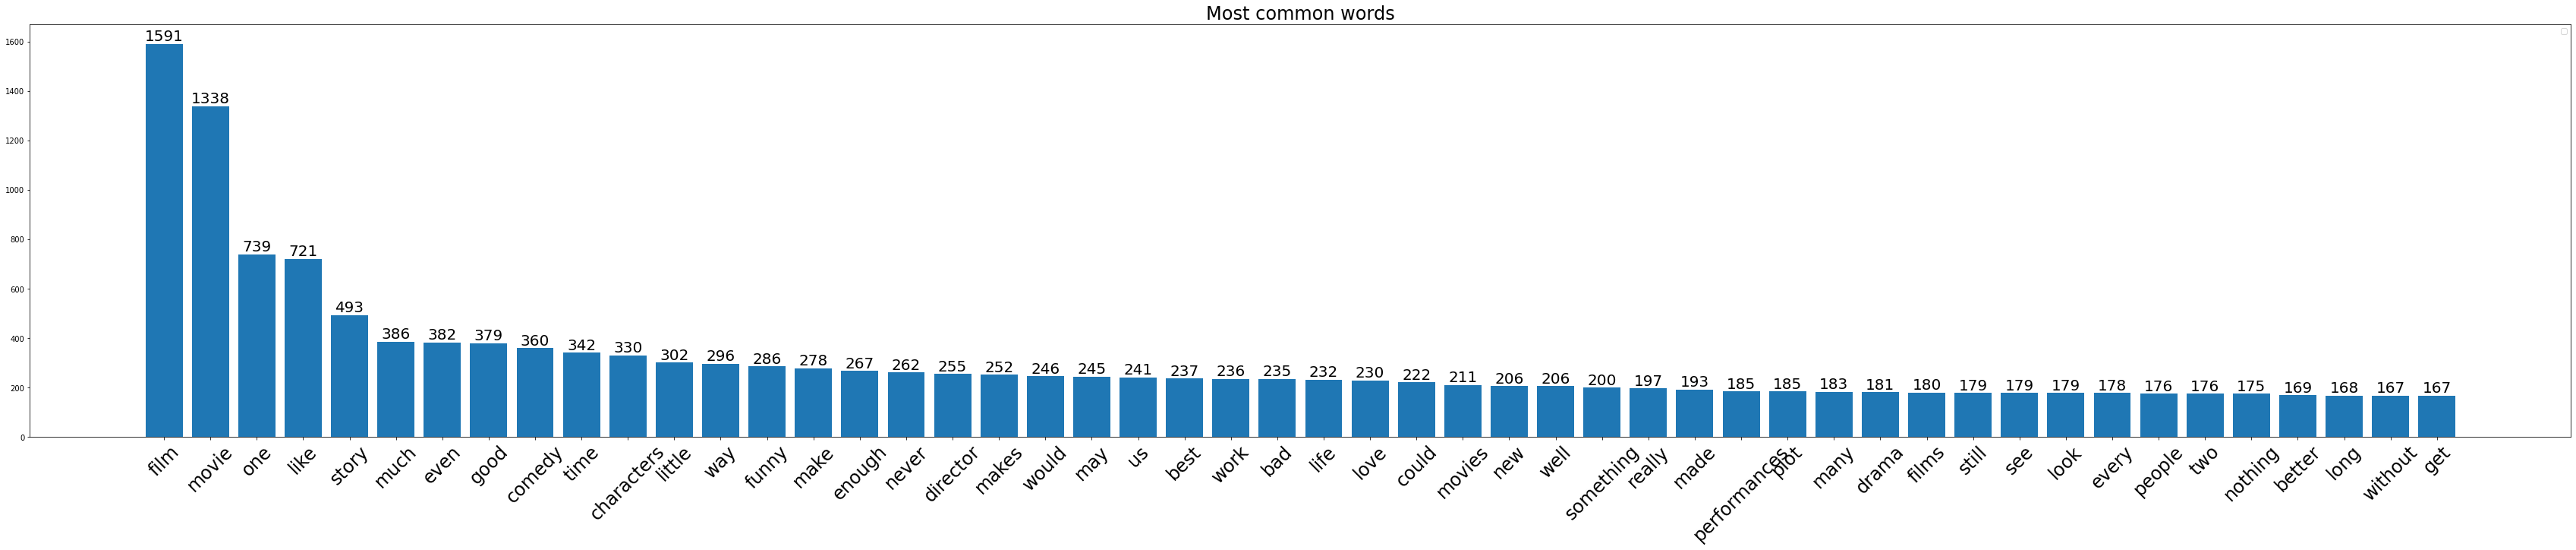

In [28]:
plot_common_words(all_tokens, remove_stop_words=True)

### 1.6 Encode sentences
The next code block creates an `encode` function that convert a sequence of tokens into integers using the vocabulary. 

In [29]:
def encode(seq_tokens, vocab, allow_unk=True):
  seq_idx = []
  for token in seq_tokens:
    if token not in vocab:
      if allow_unk:
        token = '<UNK>'
      else:
        raise KeyError('Token "%s" not in vocab' % token) 
    seq_idx.append(vocab[token])
  return seq_idx

**Exercise 5:**
Use `tensorflow.keras.preprocessing.text.Tokenizer` (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to implement more simply:
1. The construction of the vocabulary using the method `fit_on_texts`
2. The `encode` function using the method `texts_to_sequences
`

In [30]:
# prepare tokenizer
docs = [" ".join(sent) for sent in all_tokens]
t = Tokenizer() # use to build a vocabulary
t.fit_on_texts(docs) # build the vocabulary. 
vocab_size = len(t.word_index) + 1 # for the padding token.
vocab = t.word_index
print("LEN VOCAB:", len(vocab))
vocab["<PAD>"] = 0

LEN VOCAB: 17088


In [31]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(len(encoded_docs))
print(encoded_docs[0])

11855
[1, 579, 6, 2451, 5, 20, 1, 1138, 93, 6741, 3, 8, 61, 237, 5, 68, 2, 3664, 51, 2752, 32, 1375, 2452, 1697, 6742, 39, 854, 9496]


The next code block processes the dataset by: 
* Encoding each sentence into integers and adding padding. 
* Categorize labels into three categories (positive, negative, neutral). 
* Create a tensorflow dataset with encoded sentence (=input data) and category label (=target)

In [32]:
# get max sequence length
max_len = max([len(sent) for sent in all_tokens])
print("max sentence length", max_len)
stem_stop_max_len = max([len(sent) for sent in stem_stop_all_tokens])

max sentence length 51


In [33]:
def process_dataset(dataset, vocab, max_len):
  def process_example(example):
    example["inputs"] = encode(example['tokens'], vocab, allow_unk=False)
    example = binarize_label(example)
    return example
  dataset = tokenize(dataset)
  encoded_dataset = dataset.map(process_example)
  print("encoded_dataset[0]")
  pprint(encoded_dataset[0], compact=True)
  # pad sequences
  padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(encoded_dataset["inputs"], padding="post",
                                                                     truncating="post", maxlen=max_len, value=0)
  print(padded_sequences.shape)
  tfdataset = tf.data.Dataset.from_tensor_slices(
                (padded_sequences, encoded_dataset["binary_label"]))
  return tfdataset

In [34]:
def process_dataset_new_tokens(dataset, vocab, max_len):
  def process_example(example):
    example["inputs"] = encode(example['new_tokens'], vocab, allow_unk=False)
    example = binarize_label(example)
    return example
  dataset = tokenize(dataset, stem_stop=True)
  encoded_dataset = dataset.map(process_example)
  print("encoded_dataset[0]")
  pprint(encoded_dataset[0], compact=True)
  # pad sequences
  padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(encoded_dataset["inputs"], padding="post",
                                                                     truncating="post", maxlen=max_len, value=0)
  print(padded_sequences.shape)
  tfdataset = tf.data.Dataset.from_tensor_slices(
                (padded_sequences, encoded_dataset["binary_label"]))
  return tfdataset

In [35]:
train_dataset = process_dataset(train_set, vocab, max_len)
val_dataset = process_dataset(val_set, vocab, max_len)
test_dataset = process_dataset(test_set, vocab, max_len)

new_tokens_train_dataset = process_dataset_new_tokens(train_set, stem_stop_vocab, stem_stop_max_len)
new_tokens_val_dataset = process_dataset_new_tokens(val_set, stem_stop_vocab, stem_stop_max_len)
new_tokens_test_dataset = process_dataset_new_tokens(test_set, stem_stop_vocab, stem_stop_max_len)


Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-c5d6b92241e8d106.arrow


0ex [00:00, ?ex/s]

encoded_dataset[0]
{'binary_label': 1,
 'inputs': [1, 579, 6, 2451, 5, 20, 1, 1138, 93, 6741, 3, 8, 61, 237, 5, 68, 2,
            3664, 51, 2752, 32, 1375, 2452, 1697, 6742, 39, 854, 9496],
 'label': 0.6944400072097778,
 'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' "
             "and that he 's going to make a splash even greater than Arnold "
             'Schwarzenegger , Jean-Claud Van Damme or Steven Segal .',
 'tokens': ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', 'century',
            'new', 'conan', 'and', 'that', 'he', 'going', 'to', 'make', 'a',
            'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger',
            'van', 'damme', 'or', 'steven', 'segal'],
 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}
(8544, 51)


0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

encoded_dataset[0]
{'binary_label': 1,
 'inputs': [7, 2, 690, 12, 13, 690, 104, 23, 1336, 3, 14968],
 'label': 0.791670024394989,
 'sentence': "It 's a lovely film with lovely performances by Buy and Accorsi "
             '.',
 'tokens': ['it', 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by',
            'buy', 'and', 'accorsi'],
 'tree': '25|23|21|20|20|19|17|17|16|14|14|15|24|15|16|18|18|19|22|21|22|23|24|25|0'}
(1101, 51)


0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-c5d6b92241e8d106.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-c5d6b92241e8d106.arrow


encoded_dataset[0]
{'binary_label': 1,
 'inputs': [7, 2, 690, 12, 13, 690, 104, 23, 1336, 3, 14968],
 'label': 0.791670024394989,
 'sentence': "It 's a lovely film with lovely performances by Buy and Accorsi "
             '.',
 'tokens': ['it', 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by',
            'buy', 'and', 'accorsi'],
 'tree': '25|23|21|20|20|19|17|17|16|14|14|15|24|15|16|18|18|19|22|21|22|23|24|25|0'}
(1101, 51)


0ex [00:00, ?ex/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-74bcb35a72f65e96.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-74bcb35a72f65e96.arrow


encoded_dataset[0]
{'binary_label': 1,
 'inputs': [8534, 2624, 1588, 6841, 2011, 4237, 6143, 9571, 3398, 4356, 498,
            8831, 11027, 2387, 9723, 8928],
 'label': 0.6944400072097778,
 'new_tokens': ['rock', 'destin', 'centuri', 'new', 'conan', 'go', 'make',
                'splash', 'even', 'greater', 'arnold', 'schwarzenegg', 'van',
                'damm', 'steven', 'segal'],
 'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' "
             "and that he 's going to make a splash even greater than Arnold "
             'Schwarzenegger , Jean-Claud Van Damme or Steven Segal .',
 'tokens': ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', 'century',
            'new', 'conan', 'and', 'that', 'he', 'going', 'to', 'make', 'a',
            'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger',
            'van', 'damme', 'or', 'steven', 'segal'],
 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|

0ex [00:00, ?ex/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-1d918343e6e83a82.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-1d918343e6e83a82.arrow


encoded_dataset[0]
{'binary_label': 1,
 'inputs': [6026, 3710, 6026, 7441, 1378, 63],
 'label': 0.791670024394989,
 'new_tokens': ['love', 'film', 'love', 'perform', 'buy', 'accorsi'],
 'sentence': "It 's a lovely film with lovely performances by Buy and Accorsi "
             '.',
 'tokens': ['it', 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by',
            'buy', 'and', 'accorsi'],
 'tree': '25|23|21|20|20|19|17|17|16|14|14|15|24|15|16|18|18|19|22|21|22|23|24|25|0'}
(1101, 28)


0ex [00:00, ?ex/s]

encoded_dataset[0]
{'binary_label': 1,
 'inputs': [6026, 3710, 6026, 7441, 1378, 63],
 'label': 0.791670024394989,
 'new_tokens': ['love', 'film', 'love', 'perform', 'buy', 'accorsi'],
 'sentence': "It 's a lovely film with lovely performances by Buy and Accorsi "
             '.',
 'tokens': ['it', 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by',
            'buy', 'and', 'accorsi'],
 'tree': '25|23|21|20|20|19|17|17|16|14|14|15|24|15|16|18|18|19|22|21|22|23|24|25|0'}
(1101, 28)


In [36]:
# Create dataloader using batch. 
batch_size = 32
train_dataloader = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(train_dataloader))
val_dataloader = val_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(val_dataloader))
test_dataloader = test_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(test_dataloader))

(<tf.Tensor: shape=(32, 51), dtype=int32, numpy=
 array([[   7,    2,  690, ...,    0,    0,    0],
        [  55,   24,  311, ...,    0,    0,    0],
        [   3,   38,   19, ...,    0,    0,    0],
        ...,
        [   2, 4213,  617, ...,    0,    0,    0],
        [  22,   62,    6, ...,    0,    0,    0],
        [   9,    2,   64, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>)

In [37]:
# Create dataloader using batch for new_tokens (the stem_stop ones). 
batch_size = 32
new_tokens_train_dataloader = new_tokens_train_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(new_tokens_train_dataloader))
new_tokens_val_dataloader = new_tokens_val_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(new_tokens_val_dataloader))
new_tokens_test_dataloader = new_tokens_test_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(new_tokens_test_dataloader))

(<tf.Tensor: shape=(32, 28), dtype=int32, numpy=
 array([[ 6026,  3710,  6026,  7441,  1378,    63,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [ 7050,  4250, 10835,  7854,   912,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [ 6793,  6646, 10146,  2187,  8793,  4292,  4926, 11263, 11055,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [11242,  4028,  3259,  3710,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [10991,  90

## 2. Build RNN Model

In [38]:
# Build Model
def build_LSTM(seq_len, vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
  inputs = tf.keras.Input(shape=(seq_len,))
  # Embedding Layer
  embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(inputs) # PADDING IS NOT ACCOUNTED IN LOSS. 
  # LSTM Layer
  hidden = tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)(embedding) # return last hidden state by default. 
  outputs = tf.keras.layers.Dropout(rate=dropout_rate)(hidden)
  # Dense Layer - projection over the output size (i.e number of classes.)
  outputs = tf.keras.layers.Dense(output_size)(outputs)
  lstm_model = tf.keras.Model(outputs=outputs, inputs=inputs, name='lstm_for_classification')
  return lstm_model

**Exercise 6:**
Implement the same model using `tensorflow.keras.Sequential` API instead: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

In [39]:
# define model
def build_LSTM_2(seq_len, vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
  model = Sequential()
  e = Embedding(vocab_size, emb_size, input_length=seq_len, mask_zero=True)
  model.add(e)
  lstm = tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)
  model.add(lstm)
  model.add(Dense(output_size, activation='softmax')) # we compute only logits. 
  return model

## 3. Train the sentiment classifier
**Exercise 6**:  
Create a `train_LSTM` function that trains the lstm model on the train dataset. 
See the following tutorial as an example: https://www.tensorflow.org/guide/keras/train_and_evaluate


In [40]:
lstm_model = build_LSTM_2(seq_len=max_len, vocab_size=len(vocab), emb_size=32, output_size=3, rnn_units=64, dropout_rate=0.1)
new_tokens_lstm_model = build_LSTM_2(seq_len=stem_stop_max_len, vocab_size=len(stem_stop_vocab), emb_size=32, output_size=3, rnn_units=64, dropout_rate=0.1)
lr = 0.001
optimizer = tf.keras.optimizers.Adam(lr,beta_1=0.9,beta_2=0.98,epsilon=1e-9)
EPOCHS = 10

In [41]:
def train_LSTM(model, optimizer, EPOCHS, train_dataset, val_dataset, checkpoint_path):
    # save checkpoints and create callbacks
    LSTM_ckpt_path = checkpoint_path + '/' + 'LSTM-{epoch}'
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=LSTM_ckpt_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)
    ]
    # compile model with optimizer and loss, metrics = "accuracy": 
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"]) 

    print(model.summary())

    # --- starting the training ... -----------------------------------------------
    start_training = time.time()
    # fit the model to the train dataset:
    rnn_history = model.fit(train_dataset,
                            epochs=EPOCHS,
                            validation_data=val_dataset,
                            callbacks=callbacks,
                            verbose=2)
    print('Training time for {} epochs: {}'.format(EPOCHS, time.time() - start_training))
    print('training of a RNN for sentiment analysis done...')
    return rnn_history

In [42]:
import os
import time
checkpoint_path = "/checkpoints"
if not os.path.isdir(checkpoint_path):
  os.makedirs(checkpoint_path)

In [43]:
stem_stop_train_history = train_LSTM(model=new_tokens_lstm_model, optimizer=optimizer, EPOCHS=EPOCHS, train_dataset=new_tokens_train_dataloader, val_dataset=new_tokens_val_dataloader, checkpoint_path=checkpoint_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 28, 32)            372704    
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 397,731
Trainable params: 397,731
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)



Epoch 00001: val_loss improved from inf to 1.33716, saving model to /checkpoints/LSTM-1
267/267 - 10s - loss: 0.8611 - accuracy: 0.6619 - val_loss: 1.3372 - val_accuracy: 0.3824 - 10s/epoch - 38ms/step
Epoch 2/10

Epoch 00002: val_loss did not improve from 1.33716
267/267 - 6s - loss: 0.8167 - accuracy: 0.6408 - val_loss: 1.3649 - val_accuracy: 0.3971 - 6s/epoch - 21ms/step
Epoch 3/10

Epoch 00003: val_loss did not improve from 1.33716
267/267 - 6s - loss: 0.6815 - accuracy: 0.6987 - val_loss: 1.4962 - val_accuracy: 0.3768 - 6s/epoch - 21ms/step
Epoch 4/10

Epoch 00004: val_loss did not improve from 1.33716
267/267 - 6s - loss: 0.5629 - accuracy: 0.7636 - val_loss: 2.0057 - val_accuracy: 0.3842 - 6s/epoch - 21ms/step
Epoch 5/10

Epoch 00005: val_loss did not improve from 1.33716
267/267 - 6s - loss: 0.4763 - accuracy: 0.8092 - val_loss: 2.1713 - val_accuracy: 0.3888 - 6s/epoch - 21ms/step
Epoch 6/10

Epoch 00006: val_loss did not improve from 1.33716
267/267 - 6s - loss: 0.3937 - accu

In [44]:
train_history = train_LSTM(model=lstm_model, optimizer=optimizer, EPOCHS=EPOCHS, train_dataset=train_dataloader, val_dataset=val_dataloader, checkpoint_path=checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 51, 32)            546848    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 571,875
Trainable params: 571,875
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)



Epoch 00001: val_loss improved from inf to 1.38950, saving model to /checkpoints/LSTM-1
267/267 - 14s - loss: 0.8046 - accuracy: 0.6918 - val_loss: 1.3895 - val_accuracy: 0.3824 - 14s/epoch - 51ms/step
Epoch 2/10

Epoch 00002: val_loss improved from 1.38950 to 1.34747, saving model to /checkpoints/LSTM-2
267/267 - 9s - loss: 0.8202 - accuracy: 0.6505 - val_loss: 1.3475 - val_accuracy: 0.3860 - 9s/epoch - 35ms/step
Epoch 3/10

Epoch 00003: val_loss improved from 1.34747 to 1.28906, saving model to /checkpoints/LSTM-3
267/267 - 9s - loss: 0.6894 - accuracy: 0.7113 - val_loss: 1.2891 - val_accuracy: 0.4053 - 9s/epoch - 35ms/step
Epoch 4/10

Epoch 00004: val_loss did not improve from 1.28906
267/267 - 9s - loss: 0.6205 - accuracy: 0.7302 - val_loss: 1.3078 - val_accuracy: 0.4145 - 9s/epoch - 35ms/step
Epoch 5/10

Epoch 00005: val_loss did not improve from 1.28906
267/267 - 9s - loss: 0.5142 - accuracy: 0.7832 - val_loss: 1.3378 - val_accuracy: 0.4173 - 9s/epoch - 35ms/step
Epoch 6/10

Epo

In [45]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

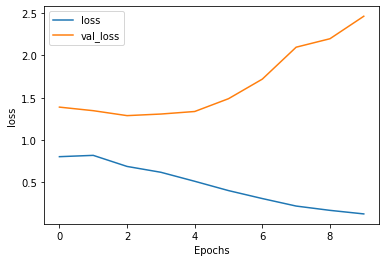

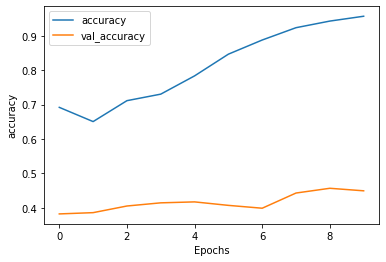

In [46]:
plot_graphs(train_history, "loss")
plot_graphs(train_history, "accuracy")


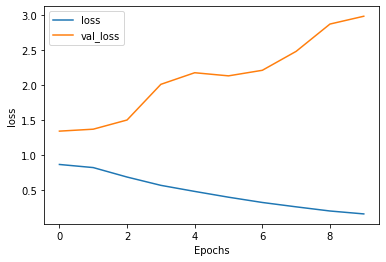

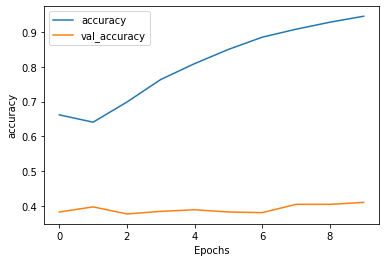

In [47]:
plot_graphs(stem_stop_train_history, "loss")
plot_graphs(stem_stop_train_history, "accuracy")

## Ex1-Q1-Answer : Stemming tokens and removing stop words clearly does not over-perform our initial model.

Let's try to modify the architecture of our LSTM


In [48]:
import gensim 
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api

glove_emb = api.load("glove-wiki-gigaword-50")
glove_emb.word_vec("work")

[==================================================] 100.0% 66.0/66.0MB downloaded


array([ 5.1359e-01,  1.9695e-01, -5.1944e-01, -8.6218e-01,  1.5494e-02,
        1.0973e-01, -8.0293e-01, -3.3361e-01, -1.6119e-04,  1.0189e-02,
        4.6734e-02,  4.6751e-01, -4.7475e-01,  1.1038e-01,  3.9327e-01,
       -4.3652e-01,  3.9984e-01,  2.7109e-01,  4.2650e-01, -6.0640e-01,
        8.1145e-01,  4.5630e-01, -1.2726e-01, -2.2474e-01,  6.4071e-01,
       -1.2767e+00, -7.2231e-01, -6.9590e-01,  2.8045e-02, -2.3072e-01,
        3.7996e+00, -1.2625e-01, -4.7967e-01, -9.9972e-01, -2.1976e-01,
        5.0565e-01,  2.5953e-02,  8.0514e-01,  1.9929e-01,  2.8796e-01,
       -1.5915e-01, -3.0438e-01,  1.6025e-01, -1.8290e-01, -3.8563e-02,
       -1.7619e-01,  2.7041e-02,  4.6842e-02, -6.2897e-01,  3.5726e-01],
      dtype=float32)

In [49]:
def lstm_modified_glove(seq_len, vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
  model = Sequential()
  e = Embedding(vocab_size, emb_size, input_length=seq_len, mask_zero=True)
  model.add(e)
  lstm = tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)
  model.add(lstm)
  model.add(Dense(output_size, activation='softmax')) # we compute only logits. 
  return model


In [50]:
def word_embedding_matrix(glove_emb, vocab, vocab_size):
  # create a weight matrix for words in training docs
  embedding_matrix = np.zeros((vocab_size, 50))
  ### ----------------------- YOUR CODE HERE --------------------------------------------- ###
  for word, i in vocab.items():
    print(word)
    # check if word is in GloVE vocabulary:
    if word in glove_emb.vocab.keys():
      embedding_vector = glove_emb.word_vec(word)
      embedding_matrix[i] = embedding_vector
  print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
  return embedding_matrix

In [ ]:
embedding_matrix = word_embedding_matrix(glove_emb, vocab, vocab_size+10)

In [67]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)

# get max lenght of sequences
max(len(i) for i in encoded_docs)

[[1, 579, 6, 2451, 5, 20, 1, 1138, 93, 6741, 3, 8, 61, 237, 5, 68, 2, 3664, 51, 2752, 32, 1375, 2452, 1697, 6742, 39, 854, 9496], [1, 3150, 2008, 6743, 4, 1, 3665, 4, 1, 2753, 4342, 6, 37, 1032, 8, 2, 6744, 4, 744, 56, 22, 4343, 2453, 1033, 808, 4344, 623, 4, 5249], [6745, 2215, 9497, 2, 9498, 4, 1280, 2, 149, 745, 937, 2, 149, 28, 280, 9499, 5, 1, 40, 11, 1, 257, 4345, 364, 671, 1, 1088, 5250, 443, 4, 1, 242], [19, 228, 23, 315, 697, 79, 34, 193, 70, 4, 6746, 938, 6747, 13, 1581, 4, 4346], [165, 1, 580, 6, 110, 340, 132], [392, 39, 22, 19, 9500, 23, 89, 4, 2454, 6748, 21, 1, 119, 3, 1, 4347, 2454, 6, 18, 1835, 258, 3, 1466, 2754], [45, 1, 6749, 855, 9, 1376, 1, 4348, 4349, 4, 1, 1281, 9, 14, 9501, 4, 2009, 3, 450, 6, 1836], [238, 4, 1, 288, 4, 4350, 3151, 6, 8, 7, 2216, 1, 393, 13, 1837, 3, 3666], [2, 305, 28, 9502, 1199, 32, 5251], [856, 2755, 6750, 1698], [53, 123, 53, 124, 53, 198, 53, 215, 53, 698, 53, 1200], [19, 100, 1089, 3667, 3152, 15, 14, 151, 19, 56, 2010, 26, 2217, 6751, 3

51

In [ ]:

# pad documents to a max length of 51 words
max_length = 51
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding= 'post')
print(padded_docs)


padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(encoded_dataset["inputs"], padding="post",
                                                                     truncating="post", maxlen=max_len, value=0)
print(padded_sequences.shape)
tfdataset = tf.data.Dataset.from_tensor_slices(
                (padded_sequences, encoded_dataset["binary_label"]))

In [ ]:
model = Sequential()
e = Embedding(vocab_size+10, 50, weights=[embedding_matrix], input_length=4, trainable=False, mask_zero=True)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid' ))
# compile the model
model.compile(optimizer= 'adam' , loss= 'binary_crossentropy' , metrics=['acc'])
# summarize the model
model.summary()
# fit the model
model.fit(padded_sequences, tfdataset, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

In [ ]:
train_set["label"]

In [ ]:
# Building a Dense layer LSTM

def build_dense_LSTM(seq_len, vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
  model = Sequential()
  e = Embedding(vocab_size, emb_size, input_length=seq_len, mask_zero=True)
  model.add(e)
  lstm = tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)
  model.add(lstm)
  model.add(Dense(1))
  model.add(Dense(3)) # we compute only logits. 
  return model

dense_lstm_model = build_dense_LSTM(seq_len=max_len, vocab_size=len(vocab), emb_size=32, output_size=3, rnn_units=64, dropout_rate=0.1)
dense_new_tokens_lstm_model = build_dense_LSTM(seq_len=stem_stop_max_len, vocab_size=len(stem_stop_vocab), emb_size=32, output_size=3, rnn_units=64, dropout_rate=0.1)

dense_stem_stop_train_history = train_LSTM(model=dense_new_tokens_lstm_model, optimizer=optimizer, EPOCHS=EPOCHS, train_dataset=new_tokens_train_dataloader, val_dataset=new_tokens_val_dataloader, checkpoint_path=checkpoint_path)

In [ ]:
from keras.layers import LSTM
from keras.layers import Bidirectional

# Building a bidirectional LSTM
def build_LSTM_bidirectional(seq_len, vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
  model = Sequential()
  e = Embedding(vocab_size, emb_size, input_length=seq_len, mask_zero=True)
  model.add(e)
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)))
  model.add(Dense(3)) # we compute only logits. 
  return model

bidirectional_lstm_model = build_dense_LSTM(seq_len=max_len, vocab_size=len(vocab), emb_size=32, output_size=3, rnn_units=64, dropout_rate=0.1)
bidirectional_new_tokens_lstm_model = build_dense_LSTM(seq_len=stem_stop_max_len, vocab_size=len(stem_stop_vocab), emb_size=32, output_size=3, rnn_units=64, dropout_rate=0.1)
bidirectional_stem_stop_train_history = train_LSTM(model=bidirectional_new_tokens_lstm_model, optimizer=optimizer, EPOCHS=EPOCHS, train_dataset=new_tokens_train_dataloader, val_dataset=new_tokens_val_dataloader, checkpoint_path=checkpoint_path)

#### add gradient clipping to limit exploding gradients: https://www.tensorflow.org/api_docs/python/tf/clip_by_norm

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr,beta_1=0.9,beta_2=0.98,epsilon=1e-9, clipnorm=1.0)
clipping_glove_stem_stop_train_history = train_LSTM(model=new_tokens_lstm_model_glove, optimizer=optimizer, EPOCHS=EPOCHS, train_dataset=new_tokens_train_dataloader, val_dataset=new_tokens_val_dataloader, checkpoint_path=checkpoint_path)

## 4. Predictions on test dataset

In [ ]:
test_loss, test_acc = lstm_model.evaluate(test_dataloader)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
#predict on a sample text without padding.
sample_text = 'The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.'
sample_tokens = sample_text.lower().split()
sample_tokens = [w for w in sample_tokens if w.isalpha()]
sample_text_encoded = encode(sample_tokens, vocab)
sample_text_encoded = tf.keras.preprocessing.sequence.pad_sequences([sample_text_encoded], padding="post",
                                                                     truncating="post", maxlen=max_len, value=0)
print(sample_text_encoded)

In [ ]:
sample_text_encoded = tf.constant(sample_text_encoded, dtype=tf.int32)
predictions = lstm_model.predict(sample_text_encoded)
predictions_probs = tf.nn.softmax(predictions)
print(predictions_probs)
predicted_label  = tf.argmax(predictions_probs, axis=-1)
print("predicted label {} with probs {}".format(predicted_label, tf.squeeze(predictions_probs)[tf.squeeze(predicted_label).numpy()]))